# Muon Tutorial

For understanding of the [increasingly popular muon optimizer](https://arxiv.org/abs/2502.16982v1)

Primary reference: https://kellerjordan.github.io/posts/muon/

https://github.com/KellerJordan/Muon/blob/master/muon.py



## Background

**Notation**: 
- $\theta \in \mathbb{R}^d$ = parameters (model weights)
- $g_t \in \mathbb{R}^d$ = gradient at step $t$
- $\alpha \in \mathbb{R}$ = learning rate (scalar)
- $\beta, \beta_1, \beta_2 \in [0,1]$ = decay rates (scalars)
- $\epsilon \in \mathbb{R}$ = numerical stability constant (scalar, typically small)
- $\lambda \in \mathbb{R}$ = weight decay coefficient (scalar)

### 1. SGD

$$\theta_t = \theta_{t-1} - \alpha \cdot g_t$$

**Dimensionality**: $g_t$ same shape as $\theta$

Basic gradient descent. Moves directly opposite to gradient with fixed learning rate

### 2. SGD + Momentum

$$v_t = \beta \cdot v_{t-1} + (1-\beta) \cdot g_t \quad \text{[build velocity]}$$
$$\theta_t = \theta_{t-1} - \alpha \cdot v_t \quad \text{[move with velocity]}$$

**Dimensionality**: $v_t$ same shape as $\theta$

Adds velocity memory. Exponential moving average of gradients. Smooths updates and accelerates in consistent directions

### 3. RMSProp

$$v_t = \beta \cdot v_{t-1} + (1-\beta) \cdot g_t^2 \quad \text{[scale track]}$$
$$\theta_t = \theta_{t-1} - \alpha \cdot \frac{g_t}{\sqrt{v_t + \epsilon}} \quad \text{[adaptive scaling]}$$

**Dimensionality**: $v_t$ same shape as $\theta$

Adds adaptive scaling per-parameter. "Scale track" = exponential moving average of squared gradients (tracks gradient magnitude history). Dividing by $\sqrt{v_t}$ gives larger steps to params with small gradients, smaller steps to those with large gradients. Per-parameter adaptive rates

### 4. Adam

$$m_t = \beta_1 \cdot m_{t-1} + (1-\beta_1) \cdot g_t \quad \text{[momentum track]}$$
$$v_t = \beta_2 \cdot v_{t-1} + (1-\beta_2) \cdot g_t^2 \quad \text{[scale track]}$$
$$\theta_t = \theta_{t-1} - \alpha \cdot \frac{\hat{m}_t}{\sqrt{\hat{v}_t + \epsilon}} \quad \text{[combine both]}$$

**Dimensionality**: $m_t$, $v_t$, $\theta$ all same shape (element-wise)

Adam $\approx$ "RMSProp + Momentum". Combines both velocity AND scale memory

### 5. AdamW

$$m_t = \beta_1 \cdot m_{t-1} + (1-\beta_1) \cdot g_t \quad \text{[momentum track]}$$
$$v_t = \beta_2 \cdot v_{t-1} + (1-\beta_2) \cdot g_t^2 \quad \text{[scale track]}$$
$$\theta_t = \theta_{t-1} - \alpha \cdot \frac{\hat{m}_t}{\sqrt{\hat{v}_t + \epsilon}} - \alpha \cdot \lambda \cdot \theta_{t-1} \quad \text{[Adam + weight decay]}$$

**Key difference**: Weight decay $(\lambda \cdot \theta_{t-1})$ applied directly to parameters (decoupled), not added to gradients like typical regularization. More effective regularization with Adam's adaptive rates




#### Example: Why L2 Regularization is Weaker in Adam

L2 regularization: $g_t \leftarrow g_t + \lambda \cdot \theta_{t-1}$

Goes through Adam:
The regularization term $\lambda \cdot \theta_{t-1}$ enters $m_t$, then gets divided by $\sqrt{v_t}$:
$$\text{regularization contribution} \propto \frac{\lambda \cdot \theta_{t-1}}{\sqrt{v_t}}$$

AdamW decouples weight decay:
$$\theta_t = \theta_{t-1} - \alpha \cdot \frac{m_t}{\sqrt{v_t} + \epsilon} - \alpha \cdot \lambda \cdot \theta_{t-1}$$

Consistent $\alpha \cdot \lambda$ across all parameters

## Second-Order Optimizers: Shampoo

All the methods above (SGD, Momentum, RMSProp, Adam, AdamW) are **first-order optimizers** — they only use gradient information $g_t = \nabla_\theta L$.

**Second-order optimizers** additionally use curvature information from the Hessian matrix $H = \nabla^2_\theta L$.

### Newton's Method (Ideal Second-Order)

$$\theta_t = \theta_{t-1} - \alpha \cdot H^{-1} \cdot g_t$$

**Dimensionality**: $H \in \mathbb{R}^{d \times d}$ where $d = \text{dim}(\theta)$

**Problem**: For a neural network with $d = 1\text{B}$ parameters, $H$ requires $10^{18}$ elements — computationally intractable!

### Shampoo: Tractable Second-Order Optimization

Shampoo approximates the full Hessian using **Kronecker factorization** for matrix parameters.

For a weight matrix $W \in \mathbb{R}^{m \times n}$ with gradient $G \in \mathbb{R}^{m \times n}$:

$$L_t = \beta \cdot L_{t-1} + (1-\beta) \cdot G \cdot G^T \quad \text{(left preconditioner)}$$
$$R_t = \beta \cdot R_{t-1} + (1-\beta) \cdot G^T \cdot G \quad \text{(right preconditioner)}$$
$$W_t = W_{t-1} - \alpha \cdot L_t^{-1/4} \cdot G \cdot R_t^{-1/4}$$

**Dimensionality**: $L_t \in \mathbb{R}^{m \times m}$, $R_t \in \mathbb{R}^{n \times n}$

**Key insight**: Instead of tracking $\mathcal{O}(m^2n^2)$ Hessian elements, Shampoo tracks $\mathcal{O}(m^2 + n^2)$ preconditioning matrices.

**Cost**: Still requires matrix inverse roots ($L^{-1/4}$, $R^{-1/4}$), which are expensive for large matrices.

### Why Muon is Different

Muon takes inspiration from second-order methods but uses a completely different approach:
- **No Hessian approximation** — only uses gradient information
- **Orthogonalization** — projects updates onto the nearest semi-orthogonal matrix
- **Newton-Schulz iteration** — fast, matrix-inverse-free orthogonalization

Muon asks: *What if we constrain updates to lie on the orthogonal manifold instead of following curvature?*

https://thinkingmachines.ai/blog/modular-manifolds/

## Muon

### Muon Formulation

Muon is designed for **2D parameter matrices** (e.g., weight matrices in neural network hidden layers).

For a weight matrix $W \in \mathbb{R}^{m \times n}$ with gradient $G_t \in \mathbb{R}^{m \times n}$:

**Step 1: Momentum update (like SGD+Momentum)**
$$M_t = \beta \cdot M_{t-1} + G_t$$

**Step 2: Orthogonalize via Newton-Schulz iteration**
$$U_t = \text{NS}(M_t) \quad \text{(project to nearest semi-orthogonal matrix)}$$

**Step 3: Apply orthogonalized update**
$$W_t = W_{t-1} - \alpha \cdot U_t$$

**Dimensionality**: $M_t, U_t, G_t, W \in \mathbb{R}^{m \times n}$

### Semi-Orthogonality

A matrix $U \in \mathbb{R}^{m \times n}$ is **semi-orthogonal** when:
- If $m \leq n$: $U^T U = I_m$ (tall/square matrix, orthonormal rows)
- If $m \geq n$: $U U^T = I_n$ (wide/square matrix, orthonormal columns)

For square matrices ($m = n$), semi-orthogonal = orthogonal = $U^T U = U U^T = I$.

### Newton-Schulz Iteration

The Newton-Schulz (NS) method projects $M$ to its nearest semi-orthogonal matrix via iteration:

$$X_0 = \frac{M}{\|M\|_F}$$
$$X_{k+1} = X_k \cdot (a I + b X_k^T X_k + c (X_k^T X_k)^2)$$

After several iterations (typically 5), $X_k$ converges such that $X_k^T X_k \approx I$ (if $m \leq n$) or $X_k X_k^T \approx I$ (if $m \geq n$).

**Muon's tuned coefficients**: $a = 3.4445$, $b = -4.7750$, $c = 2.0315$

### Why Orthogonalization?

**Comparison**:
- **AdamW**: Scales updates inversely to $\sqrt{v_t}$ (historical gradient variance) → shrinks steps in high-variance directions
- **Muon**: Projects updates to semi-orthogonal matrices → preserves update norm while ensuring columns/rows are orthonormal

This helps when rare but important gradient directions appear that would be suppressed by Adam's adaptive scaling.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")
np.random.seed(42)

In [2]:
def newton_schulz(M, steps=5):
    """Newton-Schulz iteration to find nearest semi-orthogonal matrix"""
    # Muon's tuned coefficients
    a, b, c = 3.4445, -4.7750, 2.0315

    m, n = M.shape

    # Transpose if tall matrix (more rows than columns)
    X = M.copy()
    if m > n:
        X = X.T

    # Normalize to ensure spectral norm is at most 1
    X = X / (np.linalg.norm(X, ord="fro") + 1e-7)

    # Perform Newton-Schulz iterations
    for _ in range(steps):
        A = X @ X.T  # X @ X^T
        B = b * A + c * (A @ A)  # quintic polynomial
        X = a * X + B @ X

    # Transpose back if we transposed initially
    if m > n:
        X = X.T
    return X


# Test with a random matrix
M = np.random.randn(4, 5)
U = newton_schulz(M, steps=5)

print("Original matrix M (4x5):")
print(M)
# print(f"\nFrobenius norm: {np.linalg.norm(M, 'fro'):.4f}")
print("\nOrthogonalized matrix U:")
print(U)
# print(f"\nFrobenius norm: {np.linalg.norm(U, 'fro'):.4f}")

Original matrix M (4x5):
[[ 0.49671415 -0.1382643   0.64768854  1.52302986 -0.23415337]
 [-0.23413696  1.57921282  0.76743473 -0.46947439  0.54256004]
 [-0.46341769 -0.46572975  0.24196227 -1.91328024 -1.72491783]
 [-0.56228753 -1.01283112  0.31424733 -0.90802408 -1.4123037 ]]

Orthogonalized matrix U:
[[ 0.30060777  0.11922394  0.5994228   0.6718542  -0.3848025 ]
 [-0.18559539  0.63448815  0.58617684 -0.08171142  0.09215548]
 [ 0.15618686  0.01645571  0.06959398 -0.63667951 -0.75938956]
 [-0.55916559 -0.45511285  0.3804142  -0.18846903 -0.37350369]]


In [3]:
# Verify semi-orthogonality
# Note: Muon's NS iteration doesn't produce perfect orthogonality!
# It produces something like US'V^T where S' has diagonal ~Uniform(0.5, 1.5)
# This is intentional - see https://github.com/KellerJordan/Muon/blob/master/muon.py lines 11-13

# For 4x5 matrix (m < n), check X @ X^T (should be closer to I_4)
XXt = U @ U.T
I_m = np.eye(U.shape[0])

print("U @ U^T (for wide matrix, this should be closer to identity):")
print(XXt)
print(f"\nDistance from I_4: {np.linalg.norm(XXt - I_m, 'fro'):.6f}")

# Also show U^T @ U for comparison
UtU = U.T @ U
print(f"\nFor comparison, distance of U^T @ U from I_5: {np.linalg.norm(UtU - np.eye(5), 'fro'):.6f}")

# Compare to original matrix M
print(f"\n--- Comparison to original matrix M ---")
print(f"Original M @ M^T distance from identity: {np.linalg.norm(M @ M.T - I_m, 'fro'):.6f}")
MtM = M.T @ M
print(f"Original M^T @ M distance from identity: {np.linalg.norm(MtM - np.eye(5), 'fro'):.6f}")

U @ U^T (for wide matrix, this should be closer to identity):
[[ 1.06334811  0.28086271 -0.04491169  0.02278053]
 [ 0.28086271  0.79579354  0.00428985  0.01898451]
 [-0.04491169  0.00428985  1.01154175  0.33528019]
 [ 0.02278053  0.01898451  0.33528019  0.83953442]]

Distance from I_4: 0.678247

For comparison, distance of U^T @ U from I_5: 1.208312

--- Comparison to original matrix M ---
Original M @ M^T distance from identity: 11.402025
Original M^T @ M distance from identity: 11.445793


**Note**: The Frobenius norm $\|A\|_F = \sqrt{\sum_{i,j} A_{i,j}^2}$ is the matrix generalization of the Euclidean norm (square root of sum of squared elements).

### Comparison: AdamW vs Muon

Muon should only be used for hidden weight layers (because it assumes matrix behavior for parameeters). The input embedding, final output layer,
and any internal gains or biases should be optimized using a standard method such as AdamW.

Let's compare how AdamW and Muon optimize a simple 2D quadratic function with different curvature in each dimension.

In [4]:
# Objective: elongated quadratic bowl (high curvature in x, low in y)
def objective(w):
    """f(w) = 50*x^2 + y^2"""
    return 50 * w[0] ** 2 + w[1] ** 2


def gradient(w):
    """∇f(w) = [100*x, 2*y]"""
    return np.array([100 * w[0], 2 * w[1]])


# Simple AdamW implementation
def adamw_step(
    w, g, m, v, t, alpha=0.01, beta1=0.9, beta2=0.999, eps=1e-8, lambda_=0.01
):
    m = beta1 * m + (1 - beta1) * g
    v = beta2 * v + (1 - beta2) * g**2
    m_hat = m / (1 - beta1**t)
    v_hat = v / (1 - beta2**t)
    w_new = w - alpha * (m_hat / (np.sqrt(v_hat) + eps) + lambda_ * w)
    return w_new, m, v


# Muon implementation with Nesterov momentum
def muon_step(w, g, m, t, alpha=0.01, beta=0.95):
    # Update momentum buffer
    m = beta * m + (1 - beta) * g

    # Nesterov: blend current grad with updated momentum
    update = (1 - beta) * g + beta * m

    # Reshape to column vector for Newton-Schulz
    update_col = update.reshape(-1, 1)
    u_col = newton_schulz(update_col, steps=5)

    # Apply scaling factor
    scale = max(1, update_col.shape[0] / update_col.shape[1]) ** 0.5
    u_col = u_col * scale

    u = u_col.flatten()
    w_new = w - alpha * u
    return w_new, m

In [5]:
np.random.seed(42)
steps = 100
w_init = np.array([1.0, 1.0])

# AdamW trajectory
w_adamw = w_init.copy()
m_adamw = np.zeros(2)
v_adamw = np.zeros(2)
trajectory_adamw = [w_adamw.copy()]
loss_adamw = [objective(w_adamw)]

for t in range(1, steps + 1):
    g = gradient(w_adamw)
    w_adamw, m_adamw, v_adamw = adamw_step(
        w_adamw, g, m_adamw, v_adamw, t, alpha=0.1, lambda_=0.01
    )
    trajectory_adamw.append(w_adamw.copy())
    loss_adamw.append(objective(w_adamw))

# Muon trajectory - larger learning rate since updates are normalized
w_muon = w_init.copy()
m_muon = np.zeros(2)
trajectory_muon = [w_muon.copy()]
loss_muon = [objective(w_muon)]

for t in range(1, steps + 1):
    g = gradient(w_muon)
    w_muon, m_muon = muon_step(w_muon, g, m_muon, t, alpha=0.1, beta=0.95)
    trajectory_muon.append(w_muon.copy())
    loss_muon.append(objective(w_muon))

trajectory_adamw = np.array(trajectory_adamw)
trajectory_muon = np.array(trajectory_muon)

print(f"AdamW final position: {trajectory_adamw[-1]}")
print(f"Muon final position: {trajectory_muon[-1]}")
print(f"\nAdamW final loss: {objective(trajectory_adamw[-1]):.8f}")
print(f"Muon final loss: {objective(trajectory_muon[-1]):.8f}")
print(f"Optimum loss: 0.0")

AdamW final position: [0.00301293 0.00301293]
Muon final position: [0.04746009 0.07497215]

AdamW final loss: 0.00046297
Muon final loss: 0.11824382
Optimum loss: 0.0


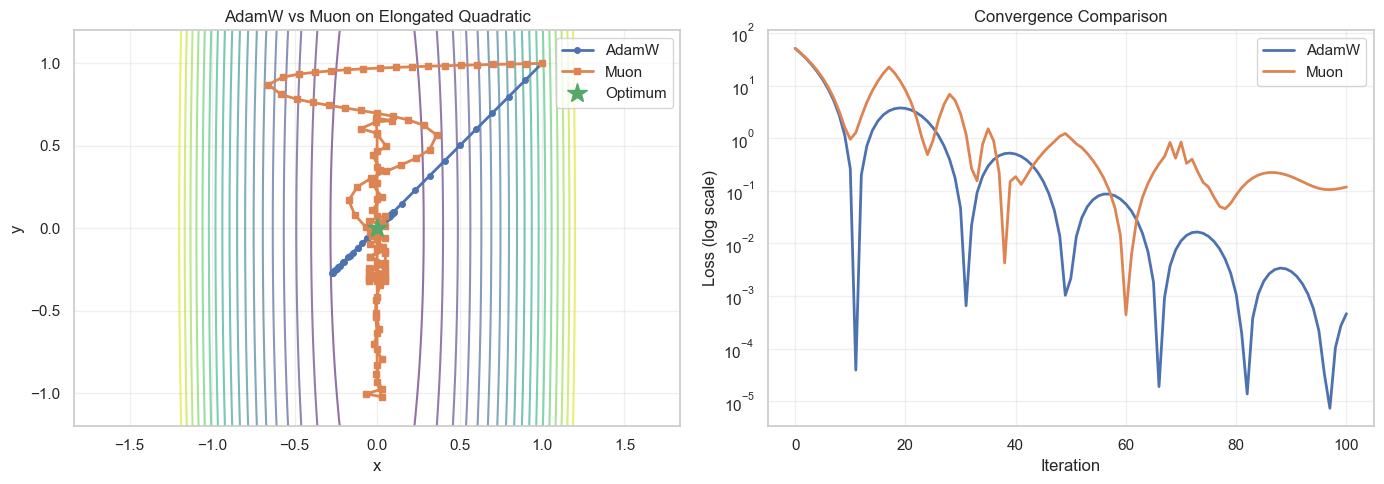

In [6]:
# Visualize optimization paths and convergence
highlight_epoch = None  # User-specified epoch of interest

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Contour plot with paths
x = np.linspace(-1.2, 1.2, 100)
y = np.linspace(-1.2, 1.2, 100)
X, Y = np.meshgrid(x, y)
Z = 50 * X**2 + Y**2

ax1.contour(X, Y, Z, levels=20, alpha=0.6, cmap="viridis")
ax1.plot(
    trajectory_adamw[:, 0],
    trajectory_adamw[:, 1],
    "o-",
    label="AdamW",
    linewidth=2,
    markersize=4,
)
ax1.plot(
    trajectory_muon[:, 0],
    trajectory_muon[:, 1],
    "s-",
    label="Muon",
    linewidth=2,
    markersize=4,
)
if highlight_epoch:
    ax1.scatter(
        trajectory_adamw[highlight_epoch, 0],
        trajectory_adamw[highlight_epoch, 1],
        color="red",
        s=150,
        marker="D",
        zorder=5,
        edgecolors="black",
        linewidths=2,
        label=f"AdamW Epoch {highlight_epoch}",
    )
    ax1.scatter(
        trajectory_muon[highlight_epoch, 0],
        trajectory_muon[highlight_epoch, 1],
        color="orange",
        s=150,
        marker="D",
        zorder=5,
        edgecolors="black",
        linewidths=2,
        label=f"Muon Epoch {highlight_epoch}",
    )
ax1.plot(0, 0, "g*", markersize=15, label="Optimum")
ax1.set_xlabel("x")
ax1.set_ylabel("y")
ax1.set_title("AdamW vs Muon on Elongated Quadratic")
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.axis("equal")

# Loss curves
ax2.plot(loss_adamw, label="AdamW", linewidth=2)
ax2.plot(loss_muon, label="Muon", linewidth=2)
if highlight_epoch:
    ax2.axvline(x=highlight_epoch, color="gray", linestyle="--", linewidth=1.5, alpha=0.7)
    ax2.scatter(
        [highlight_epoch],
        [loss_adamw[highlight_epoch]],
        color="red",
        s=100,
        zorder=5,
        marker="D",
        edgecolors="black",
        linewidths=2,
    )
    ax2.scatter(
        [highlight_epoch],
        [loss_muon[highlight_epoch]],
        color="orange",
        s=100,
        zorder=5,
        marker="D",
        edgecolors="black",
        linewidths=2,
    )
ax2.set_xlabel("Iteration")
ax2.set_ylabel("Loss (log scale)")
ax2.set_yscale("log")
ax2.set_title("Convergence Comparison")
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Let's try something more challenging:

In [7]:
# Rosenbrock function: f(x,y) = (a-x)^2 + b(y-x^2)^2
# Classic ill-conditioned problem with narrow parabolic valley
def rosenbrock(w, a=1, b=100):
    return (a - w[0]) ** 2 + b * (w[1] - w[0] ** 2) ** 2


def rosenbrock_grad(w, a=1, b=100):
    dx = -2 * (a - w[0]) - 4 * b * w[0] * (w[1] - w[0] ** 2)
    dy = 2 * b * (w[1] - w[0] ** 2)
    return np.array([dx, dy])


# Run optimization
np.random.seed(42)
steps = 500
w_init = np.array([-0.5, 2.0])

# AdamW on Rosenbrock
w_adamw_rb = w_init.copy()
m_adamw_rb = np.zeros(2)
v_adamw_rb = np.zeros(2)
loss_adamw_rb = [rosenbrock(w_adamw_rb)]
trajectory_adamw_rb = [w_adamw_rb.copy()]

for t in range(1, steps + 1):
    g = rosenbrock_grad(w_adamw_rb)
    w_adamw_rb, m_adamw_rb, v_adamw_rb = adamw_step(
        w_adamw_rb, g, m_adamw_rb, v_adamw_rb, t, alpha=0.1, lambda_=0.01
    )
    loss_adamw_rb.append(rosenbrock(w_adamw_rb))
    trajectory_adamw_rb.append(w_adamw_rb.copy())

# Muon on Rosenbrock
w_muon_rb = w_init.copy()
m_muon_rb = np.zeros(2)
loss_muon_rb = [rosenbrock(w_muon_rb)]
trajectory_muon_rb = [w_muon_rb.copy()]

for t in range(1, steps + 1):
    g = rosenbrock_grad(w_muon_rb)
    w_muon_rb, m_muon_rb = muon_step(w_muon_rb, g, m_muon_rb, t, alpha=0.1, beta=0.95)
    loss_muon_rb.append(rosenbrock(w_muon_rb))
    trajectory_muon_rb.append(w_muon_rb.copy())

trajectory_adamw_rb = np.array(trajectory_adamw_rb)
trajectory_muon_rb = np.array(trajectory_muon_rb)

print(f"Rosenbrock function (optimum at [1, 1]):")
print(f"AdamW final position: {w_adamw_rb}")
print(f"Muon final position:  {w_muon_rb}")
print(f"")
print(f"AdamW final loss: {rosenbrock(w_adamw_rb):.6f}")
print(f"Muon final loss:  {rosenbrock(w_muon_rb):.6f}")

Rosenbrock function (optimum at [1, 1]):
AdamW final position: [0.29302072 0.08382726]
Muon final position:  [0.54218353 0.22388286]

AdamW final loss: 0.500233
Muon final loss:  0.700718


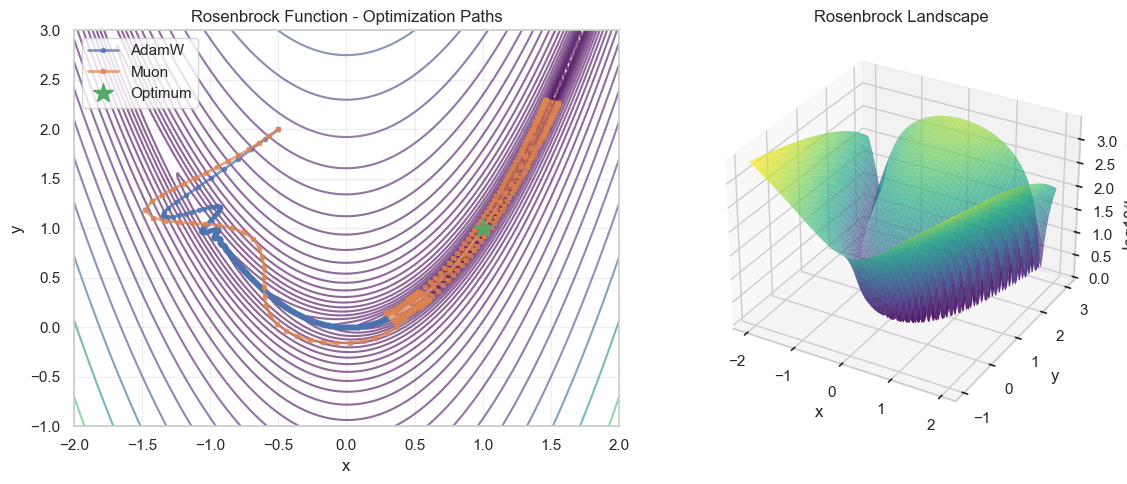

In [8]:
# Visualize the Rosenbrock landscape
highlight_epoch = None  # User-specified epoch of interest

x = np.linspace(-2, 2, 200)
y = np.linspace(-1, 3, 200)
X, Y = np.meshgrid(x, y)
Z = (1 - X) ** 2 + 100 * (Y - X**2) ** 2

plt.figure(figsize=(12, 5))

# Contour plot with optimization paths
plt.subplot(1, 2, 1)
plt.contour(X, Y, Z, levels=np.logspace(-1, 3.5, 30), cmap="viridis", alpha=0.6)
plt.plot(
    trajectory_adamw_rb[:, 0],
    trajectory_adamw_rb[:, 1],
    "o-",
    label="AdamW",
    linewidth=2,
    markersize=3,
    alpha=0.7,
)
plt.plot(
    trajectory_muon_rb[:, 0],
    trajectory_muon_rb[:, 1],
    "s-",
    label="Muon",
    linewidth=2,
    markersize=3,
    alpha=0.7,
)
if highlight_epoch:
    plt.scatter(
        trajectory_adamw_rb[highlight_epoch, 0],
        trajectory_adamw_rb[highlight_epoch, 1],
        color="red",
        s=150,
        marker="D",
        zorder=5,
        edgecolors="black",
        linewidths=2,
        label=f"AdamW Epoch {highlight_epoch}",
    )
    plt.scatter(
        trajectory_muon_rb[highlight_epoch, 0],
        trajectory_muon_rb[highlight_epoch, 1],
        color="orange",
        s=150,
        marker="D",
        zorder=5,
        edgecolors="black",
        linewidths=2,
        label=f"Muon Epoch {highlight_epoch}",
    )
plt.plot(1, 1, "g*", markersize=15, label="Optimum")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Rosenbrock Function - Optimization Paths")
plt.legend()
plt.grid(True, alpha=0.3)

# 3D surface plot
ax = plt.subplot(1, 2, 2, projection="3d")
ax.plot_surface(X, Y, np.log10(Z + 1), cmap="viridis", alpha=0.7, edgecolor="none")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("log10(Loss + 1)")
ax.set_title("Rosenbrock Landscape")
plt.tight_layout()
plt.show()

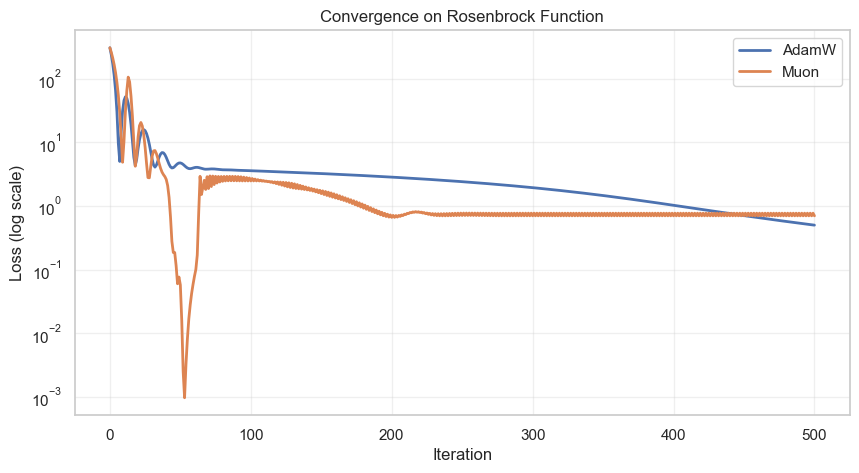

In [9]:
# Plot loss curves
plt.figure(figsize=(10, 5))
plt.plot(loss_adamw_rb, label="AdamW", linewidth=2)
plt.plot(loss_muon_rb, label="Muon", linewidth=2)
if highlight_epoch:
    plt.axvline(x=highlight_epoch, color="red", linestyle="--", linewidth=2, alpha=0.7)
    plt.scatter(
        [highlight_epoch],
        [loss_muon_rb[highlight_epoch]],
        color="red",
        s=100,
        zorder=5,
        marker="*",
        edgecolors="black",
        linewidths=2,
    )
plt.xlabel("Iteration")
plt.ylabel("Loss (log scale)")
plt.yscale("log")
plt.title("Convergence on Rosenbrock Function")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## Muon CLIP

https://arxiv.org/abs/2507.20534

https://fireworks.ai/blog/muonclip


During large-scale training with Muon, attention logits can explode due to the spectral norms of query and key weight matrices growing unboundedly, causing training instability, loss spikes, and crashes.

Attention scores are computed as:
$$\text{score}_{i,j} = \frac{(x_i W_q)(x_j W_k)^T}{\sqrt{d}} \propto \|W_q\|_2 \cdot \|W_k\|_2$$

Muon's orthogonalization produces full-rank updates (like pushing evenly in all directions simultaneously), unlike Adam's low-rank updates (a few large singular values, most are tiny).

### QK-Clip

QK-Clip rescales $W_q$ and $W_k$ after each update when the maximum attention score exceeds threshold $t$.

**Algorithm:**

1. Compute max score: $\text{score}_{\max} = \max_{i,j} \frac{(XW_q)(XW_k)^T}{\sqrt{d}}$

2. If $\text{score}_{\max} > t$, compute per-head scale factor:
   $$s_h = \max\left(1, \frac{\text{score}_{\max,h}}{t}\right)^{0.5}$$

3. Rescale weights:
   $$W_q^h \leftarrow W_q^h / \sqrt{s_h}, \quad W_k^h \leftarrow W_k^h / \sqrt{s_h}$$

**Key properties:**
- Clipping happens at the source (weights) without distorting attention distributions
- Applied per-head to avoid over-regularizing stable heads
- Self-deactivating: Kimi K2 used $t=100$, which was only active for the first 70k steps before naturally decaying
- Enabled training on 15.5T tokens with zero loss spikes

**Advantages over alternatives:**
- Logit soft-capping: distorts attention probabilities
- QK-normalization: incompatible with Multi-head Latent Attention (MLA)